## Практическое задание

Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность)

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.datasets import fashion_mnist


In [66]:
(X_images_train, y_train), (X_images_test, y_test) = fashion_mnist.load_data()

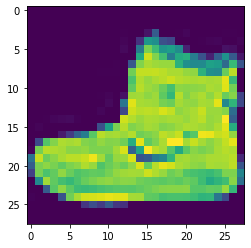

In [67]:
plt.imshow(X_images_train[0])

In [4]:
X_train = (X_images_train/127) - 1 
X_test = (X_images_test/127) - 1 

In [5]:
X_train = X_train.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))

In [6]:
y_t = to_categorical(y_train,10)
y_tt = to_categorical(y_test,10)

In [7]:
def create_layers(model, shape):
    for i in range(0, len(shape) - 1):
        model.add(Dense(shape[i], activation='relu', input_shape=(784,)))
    model.add(Dense(10, activation='softmax'))
    return model

делаем сетку нейронов для 

In [8]:
# doing nlist of 2 neuron layers
neurons = np.linspace(2,50,7, dtype='int32')
shapes = [(i, j) for i in neurons for j in neurons]

In [9]:
neurons

array([ 2, 10, 18, 26, 34, 42, 50])

In [13]:
def model_fit(X_train, y_t, shapes=[[280, 150]], optimizer='RMSProp', ret_model=False):
    '''
    Create model and fit it on Xtrain, y_t
    Input:
        X_train, y_train.
        shapes - list of hiden layers shapes.
        optimizer - str with name of optimizer.
        ret_model - flag, if True return not only hysotry but model too.
    Output:
        histories - list of tupples in every (shape, history_object).
        optional:
            model - if ret_model=True, return model too.
    '''
    histories = []
    for shape in tqdm(shapes):
        model = Sequential(name='my_model')
        model = create_layers(model, shape)
        model.compile(
                    optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'],
                )
        h = model.fit(  
                    X_train,
                    y_t,
                    epochs=15,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=False
                )
        histories.append((shape, h))
    if ret_model:
        return histories, model
    else:
        return histories

In [14]:
histories = model_fit(X_train, y_t, shapes)

In [18]:
temp = np.zeros((7,7))
result1 = pd.DataFrame(temp, columns=neurons, index=neurons)
for history in histories:
    result1.at[history[0][0],history[0][1]] = history[1].history['val_accuracy'][-1]

In [19]:
result1

,2,10,18,26,34,42,50
2,0.694917,0.694417,0.715583,0.663500,0.728500,0.694917,0.722333
10,0.857250,0.856167,0.854500,0.855333,0.855667,0.849333,0.850000
18,0.866000,0.868917,0.867333,0.857333,0.863250,0.855250,0.865500
26,0.873250,0.855417,0.866833,0.869750,0.873667,0.865250,0.871000
34,0.872250,0.870750,0.870250,0.879833,0.877917,0.875750,0.875167
42,0.870250,0.877750,0.862250,0.878083,0.864667,0.877083,0.874417
50,0.881000,0.871417,0.875917,0.877167,0.872583,0.875000,0.875250


<AxesSubplot:>

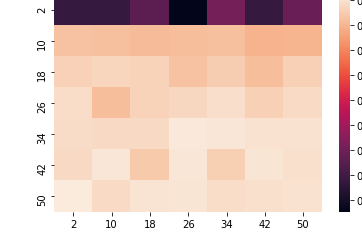

In [20]:
sns.heatmap(result1)

Видно что размер первго слоя более критичен чем размер второго слоя, так как видимо прим маленьком первом скрытоом слое, мы теряем слишком много информации, которую уже потом не восстановить. Вообще кажется разумным что если мы имеем входные данные большого размера, а на выходе всего несколько классов. То разумно делать слои постепенно уменьшаюзиеся от входного размера к выходному. Это будет своеобразное выделение признаков на каждом уровне, и потом оъединение их в более общие признаки на последующих.

In [21]:
def num_of_params(shape):
    shape.insert(0, 784)
    shape.append(10)
    result = 0
    for i in range(len(shape) - 1):
        result += shape[i] * shape[i+1]
    result += sum(shape)
    return result

In [22]:

num_of_params([280, 150])

264244

In [23]:
num_of_params([270,  150, 80])

266274

In [24]:
num_of_params([260, 150, 80, 50, 25])

261699

In [25]:
num_of_params([230, 130, 110, 100 , 90, 80, 60, 40, 30, 20 ])

262604

In [26]:
shapes = [[280, 150], [270,  150, 80], [260, 150, 80, 50, 25], [230, 130, 110, 100 , 90, 80, 60, 40, 30, 20 ]]

In [27]:
shapes

[[280, 150],
 [270, 150, 80],
 [260, 150, 80, 50, 25],
 [230, 130, 110, 100, 90, 80, 60, 40, 30, 20]]

In [29]:
histories = model_fit(X_train, y_t, shapes)

In [30]:
for h in histories:
    print(f'hiden layers: {h[0]}\n', f'val accuracy {h[1].history["val_accuracy"][-1]}')

hiden layers: [280, 150]
 val accuracy 0.8794999718666077
hiden layers: [270, 150, 80]
 val accuracy 0.8805833458900452
hiden layers: [260, 150, 80, 50, 25]
 val accuracy 0.8665000200271606
hiden layers: [230, 130, 110, 100, 90, 80, 60, 40, 30, 20]
 val accuracy 0.8619999885559082


Качество модели падает с увеличение количества слоев. Хотя на основе даного эксперимента можно только сделать вывод? что конкретно сетки такой структуры обучились хуже чем сетки дркугой структуры(если еще не учитывать разброс в обучении, хотя он не очень большой). Слишком мало опытов для смелого вывода в начале.

In [31]:
optimizers = ['Adam', 'RMSProp', 'SGD']

In [34]:
histories = []
for optimizer in optimizers:
    histories.append(model_fit(X_train, y_t, optimizer=optimizer))

In [35]:
for i in range(len(histories)):
    print(f'optimizer: {optimizers[i]}\n', f'val accuracy {histories[i][0][1].history["val_accuracy"][-1]}')

optimizer: Adam
 val accuracy 0.8820833563804626
optimizer: RMSProp
 val accuracy 0.8732500076293945
optimizer: SGD
 val accuracy 0.8712499737739563


Лучший оптимайзер в данном случае оказался Adam, но подозреваю, что если учесть близость отвтетов, то в зависимости от выбранных уровней и от кроссвалидации может в другом случае оказаться лучше и другой валидатор.

Скорей всего лучший выбор в данном варианте будет всего пара слоев с большим количеством нейронов. С оптимизатором Адам.

Возьмем лучший вариант решения. 2 слоя \[280, 150\], оптимизатор Adam.

In [36]:
histories, model1 = model_fit(X_train, y_t, shapes=[[280, 150]], optimizer='Adam', ret_model=True)

In [37]:
histories

[([280, 150], <tensorflow.python.keras.callbacks.History at 0x220abaec280>)]

In [38]:
histories[0][1].history['val_accuracy'][-1]

0.8877500295639038

In [39]:
y_test_pred = model1.predict(X_test)

In [42]:
from sklearn.metrics import multilabel_confusion_matrix

In [44]:
def make_proper_pred(array):
    return np.where(array == array.max(), 1, 0)

In [45]:
 y_pred = np.apply_along_axis(make_proper_pred, 1, y_test_pred)

In [51]:
conf_matrixes = multilabel_confusion_matrix(y_tt, y_pred)
conf_matrixes

array([[[8816,  184],
        [ 163,  837]],

       [[8968,   32],
        [  18,  982]],

       [[8776,  224],
        [ 176,  824]],

       [[8913,   87],
        [ 134,  866]],

       [[8817,  183],
        [ 202,  798]],

       [[8967,   33],
        [  52,  948]],

       [[8714,  286],
        [ 298,  702]],

       [[8953,   47],
        [ 112,  888]],

       [[8978,   22],
        [  35,  965]],

       [[8884,  116],
        [  24,  976]]], dtype=int64)

In [52]:
def precision_recall_f1(conf_matrix):
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    fn = conf_matrix[1,0]

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2*precision*recall / (precision + recall)
    
    return (precision, recall, f1)

In [69]:
classes = np.array(list(range(0,10)))
metrix = np.array(('precision', 'recall', 'f1_score'))
result = pd.DataFrame(np.zeros((classes.size, metrix.size)), columns=metrix, index=classes)
for i in range(len(conf_matrixes)):
    metrics = precision_recall_f1(conf_matrixes[i])
    result.loc[i,:] = metrics
    

In [70]:
result.sort_values(by='f1_score', ascending=False)

,precision,recall,f1_score
1,0.968442,0.982,0.975174
8,0.977710,0.965,0.971314
5,0.966361,0.948,0.957092
9,0.893773,0.976,0.933078
7,0.949733,0.888,0.917829
3,0.908709,0.866,0.886841
0,0.819785,0.837,0.828303
4,0.813456,0.798,0.805654
2,0.786260,0.824,0.804688
6,0.710526,0.702,0.706237


можно видеть что подкачали картинки 0,4,2,6 она распознаются хуже всего.

0
4
2
6


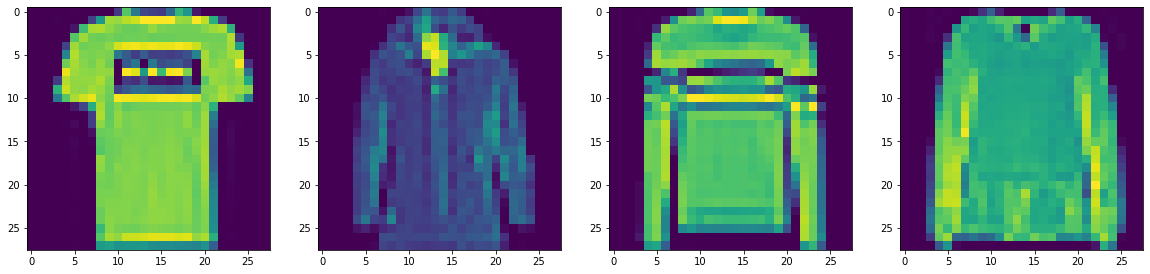

In [117]:
fig, axes = plt.subplots(1,4, figsize=((20,5)))
for i, item in enumerate([0,4,2,6]):
    axes[i].imshow(X_images_train[np.isin(y_train, item)][0])

Вот эти ребята опознались хуже всего, они весьма силно похожи друг на друга, видимо поэтоу алоритм их перепутал.